In [1]:
!nvidia-smi

Thu May 20 05:09:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install face-alignment
!pip install facenet-pytorch
!pip install timm

  Created wheel for face-alignment: filename=face_alignment-1.3.4-py2.py3-none-any.whl size=27859 sha256=1eecb0f5b13b03f25d81703501f4bb3e2c0c00a078ba9115a27e5521491c5bd0
  Stored in directory: /root/.cache/pip/wheels/a1/4d/d9/fa80a2341395ce73765c09eef97b262a048b2a763c9b689c2c
Successfully built face-alignment
     |████████████████████████████████| 1.9MB 7.5MB/s 
     |████████████████████████████████| 348kB 8.2MB/s 


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import tensorflow as tf
import numpy as np
import timm
import cv2
import os
import matplotlib.pyplot as plt
import face_alignment
import subprocess
from facenet_pytorch import InceptionResnetV1
from PIL import Image, ImageFilter
from glob import glob
from tqdm import tqdm

In [5]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=True, device ='cuda:0')

def draw_points(img, landmarks, color, thickness, isClosed=False):
    landmarks = np.array(landmarks, np.int32).reshape((-1, 1, 2))
    # cv2.polylines(img, [landmarks], isClosed, color, thickness, cv2.LINE_AA)
    cv2.polylines(img, [landmarks], isClosed, color, thickness, cv2.LINE_8)
    return img

def get_landmark(img):
    preds = fa.get_landmarks(np.asarray(img))
    if preds is None:
        return None
    preds = preds[0]

    canvas = np.full_like(img, 255)
    #chin
    # canvas = draw_points(canvas, preds[0:17], (0, 128, 128), 2)
    #left and right eyebrow
    canvas = draw_points(canvas, preds[17:22], (128, 0, 128), 2)
    canvas = draw_points(canvas, preds[22:27], (128, 0, 128), 2)
    #nose
    # canvas = draw_points(canvas, preds[27:31], (128, 0, 0), 2)
    # canvas = draw_points(canvas, preds[31:36], (128, 0, 0), 2)
    #left and right eye
    canvas = draw_points(canvas, preds[36:42], (0, 128, 0), 2, True)
    canvas = draw_points(canvas, preds[42:48], (0, 128, 0), 2, True)
    #outer and inner lip
    # canvas = draw_points(canvas, preds[48:60], (0, 0, 128), 2, True)
    canvas = draw_points(canvas, preds[60:68], (0, 0, 128), 2, True)

    img = Image.fromarray(canvas)
    # img = img.filter(ImageFilter.GaussianBlur(2))
    return img

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip


In [6]:
DEVICE = 'cuda'

def preprocess(img):
    img = img.resize((128, 128), Image.BICUBIC)
    img = np.asarray(img)
    img = img / 127.5 - 1
    img = img.transpose((2,0,1))
    return img

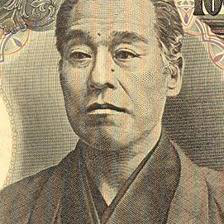

In [7]:
faces = []
landmarks = []
face = Image.open('b.jpg').convert('RGB')
faces.append(preprocess(face))
landmark = get_landmark(face)
landmarks.append(preprocess(landmark))
face

In [8]:
real_faces = torch.Tensor(faces).to(DEVICE)
faces = np.concatenate(faces)
faces = torch.Tensor(faces).to(DEVICE).unsqueeze(0)
landmarks = torch.Tensor(landmarks).to(DEVICE)
faces.shape, landmarks.shape, real_faces.shape

(torch.Size([1, 3, 128, 128]),
 torch.Size([1, 3, 128, 128]),
 torch.Size([1, 3, 128, 128]))

In [9]:
GF = 64

class ResidualBlock(nn.Module):
    def __init__(self, fin, fout):
        super().__init__()

        self.learned_shortcut = (fin != fout)

        fhid = min(fin, fout)

        self.conv = nn.Sequential(
            nn.InstanceNorm2d(fin),
            nn.LeakyReLU(0.2),
            nn.Conv2d(fin, fhid, 3, stride=1, padding=1),
            nn.InstanceNorm2d(fhid),
            nn.LeakyReLU(0.2),
            nn.Conv2d(fhid, fout, 3, stride=1, padding=1),
        )
        if self.learned_shortcut:
            self.conv_s = nn.Conv2d(fin, fout, 1, stride=1, padding=0, bias=False)

    def forward(self, x):
        if self.learned_shortcut:
            s = self.conv_s(x)
        else:
            s = x

        x = self.conv(x)
        x = s + 0.1*x

        return x

class DownBlock(nn.Module):
    def __init__(self, fin, fout, use_norm=True):
        super().__init__()

        self.use_norm = use_norm

        self.conv = nn.Conv2d(fin, fout, 3, stride=2, padding=1)
        if self.use_norm:
            self.norm = nn.InstanceNorm2d(fout)
        self.actv = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        x = self.conv(x)
        if self.use_norm:
            x = self.norm(x)
        x = self.actv(x)
        return x

class UpBlock(nn.Module):
    def __init__(self, fin, fout):
        super().__init__()

        self.net = nn.Sequential(
            ResidualBlock(fin, fout),
            ResidualBlock(fout, fout),
            ResidualBlock(fout, fout),
            nn.Upsample(scale_factor=2),
        )
    
    def forward(self, x):
        x = self.net(x)
        return x

class EncoderDownBlock(nn.Module):
    def __init__(self, fin, fout):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(fin, fout, 3, stride=2, padding=1, bias=False),
            ResidualBlock(fout, fout),
        )
    
    def forward(self, x):
        x = self.main(x)
        return x

class Encoder(nn.Module):
    def __init__(self, FRAME_NUM):
        super().__init__()

        self.encoder = nn.Sequential(
            EncoderDownBlock(FRAME_NUM, 64),
            EncoderDownBlock(64, 128),
            EncoderDownBlock(128, 256),
            EncoderDownBlock(256, 512),
            EncoderDownBlock(512, 1024),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.d0 = DownBlock(3, GF)
        self.d1 = DownBlock(GF, GF*2)
        self.d2 = DownBlock(GF*2, GF*4)
        self.d3 = DownBlock(GF*4, GF*8)
        self.d4 = DownBlock(GF*8, GF*16)

        self.u4 = UpBlock(GF*16+1024, GF*16)
        self.u3 = UpBlock(GF*(8+16), GF*8)
        self.u2 = UpBlock(GF*(4+8), GF*4)
        self.u1 = UpBlock(GF*(2+4), GF*2)
        self.u0 = UpBlock(GF*(1+2), GF)

        self.image = nn.Sequential(
            nn.Conv2d(GF, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, emb, l):
        d0 = self.d0(l)
        d1 = self.d1(d0)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)

        u = torch.cat([emb, d4], dim=1)
        # u = torch.cat([d3, emb], dim=1)

        u = self.u4(u)
        u = torch.cat([u, d3], dim=1)
        u = self.u3(u)
        u = torch.cat([u, d2], dim=1)
        u = self.u2(u)
        u = torch.cat([u, d1], dim=1)
        u = self.u1(u)
        u = torch.cat([u, d0], dim=1)
        u = self.u0(u)
        x = self.image(u)

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        m = timm.create_model('resnet18')
        m.fc = nn.Linear(512, 1)

        self.main = m.cuda().train()

    def forward(self, x):
        return self.main(x)

In [10]:
DIR = '/content/drive/MyDrive/vox_1shot_maxpool/'
ENCODER_WEIGHT_PATH = DIR + 'e.pth'
GENERATOR_WEIGHT_PATH = DIR + 'g.pth'
# DISCRIMINATOR_WEIGHT_PATH = DIR + 'd.pth'

In [11]:
encoder = Encoder(faces.size(1)).to(DEVICE).eval()
encoder.load_state_dict(torch.load(ENCODER_WEIGHT_PATH, map_location=torch.device(DEVICE)))

generator = Generator().to(DEVICE).eval()
generator.load_state_dict(torch.load(GENERATOR_WEIGHT_PATH, map_location=torch.device(DEVICE)))

# discriminator = Discriminator().to(DEVICE).eval()
# discriminator.load_state_dict(torch.load(DISCRIMINATOR_WEIGHT_PATH, map_location=torch.device(DEVICE)))

<All keys matched successfully>

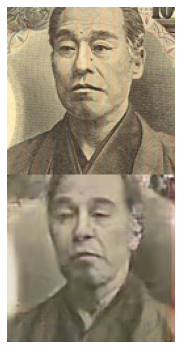

In [12]:
def print_result():
    with torch.no_grad():
        num = real_faces.size(0)
        features = encoder(faces)
        features = features.expand(num, 1024, 4, 4)
        gen = generator(features, landmarks)
    
    gen = gen.detach().cpu().permute(0,2,3,1)
    gen = np.hstack(gen)
    gen = (gen + 1) * 127.5
    
    real = real_faces.detach().cpu().permute(0,2,3,1)
    real = np.hstack(real)
    real = (real + 1) * 127.5
    
    images = np.vstack([real, gen])

    plt.figure(figsize=(num*3,num*9))
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(np.uint8(images))
    plt.show()

print_result()

In [15]:
MOV = 'b.mp4'

!rm -fr ./mov/ ./cropped_mov/
!mkdir ./mov/ ./cropped_mov/

cap = cv2.VideoCapture(MOV)
FPS = cap.get(cv2.CAP_PROP_FPS)
FRAME_COUNT = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

for i in tqdm(range(FRAME_COUNT)):
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imwrite('./cropped_mov/{:08}.jpg'.format(i), frame)

print('FPS:', FPS, 'COUNT:', FRAME_COUNT)

100%|██████████| 609/609 [00:00<00:00, 790.97it/s]

FPS: 25.0 COUNT: 609


In [16]:
prev_preds = None
curr_preds = None
next_preds = None
def get_smooth_landmark(img):
    global prev_preds, curr_preds, next_preds
    preds = fa.get_landmarks(np.asarray(img))
    if preds is None:
        return None
    preds = preds[0]
    if prev_preds is None:
        prev_preds = preds
        curr_preds = preds
        next_preds = preds
    else:
        prev_preds = curr_preds
        curr_preds = next_preds
        next_preds = preds
    preds = (prev_preds + curr_preds + next_preds) / 3

    canvas = np.full_like(img, 255)
    #chin
    # canvas = draw_points(canvas, preds[0:17], (0, 128, 128), 2)
    #left and right eyebrow
    canvas = draw_points(canvas, preds[17:22], (128, 0, 128), 2)
    canvas = draw_points(canvas, preds[22:27], (128, 0, 128), 2)
    #nose
    # canvas = draw_points(canvas, preds[27:31], (128, 0, 0), 2)
    # canvas = draw_points(canvas, preds[31:36], (128, 0, 0), 2)
    #left and right eye
    canvas = draw_points(canvas, preds[36:42], (0, 128, 0), 2, True)
    canvas = draw_points(canvas, preds[42:48], (0, 128, 0), 2, True)
    #outer and inner lip
    # canvas = draw_points(canvas, preds[48:60], (0, 0, 128), 2, True)
    canvas = draw_points(canvas, preds[60:68], (0, 0, 128), 2, True)

    img = cv2.resize(canvas, (128, 128), cv2.INTER_CUBIC)
    img = img / 127.5 - 1
    img = img.transpose((2,0,1))
    img = torch.Tensor(img).unsqueeze(0).to(DEVICE)
    return img

def to_pil(image):
    return Image.fromarray(np.uint8(image))

In [17]:
from tqdm import tqdm

!rm -fr ./gen/ ./src/ ./lm/
!mkdir ./gen/ ./src/ ./lm/

with torch.no_grad():
    features = encoder(faces)

for path in tqdm(sorted(glob('./cropped_mov/*.jpg'))):
    fname = os.path.basename(path)
    face = Image.open(path)

    lm = get_smooth_landmark(face)

    with torch.no_grad():
        gen = generator(features, lm)

    gen = (gen.detach().cpu().squeeze().permute(1,2,0) + 1) * 127.5
    gen = to_pil(np.uint8(gen))
    gen.save('./gen/'+fname)

    src = face.resize((128, 128), Image.BICUBIC)
    src.save('./src/'+fname)

    lm = (lm.detach().cpu().squeeze().permute(1,2,0) + 1) * 127.5
    lm = to_pil(lm).resize((128, 128), Image.BICUBIC)

    lm.save('./lm/'+fname)

100%|██████████| 609/609 [00:41<00:00, 14.74it/s]


In [18]:
!rm -fr ./out/
!mkdir ./out/

filenames = sorted(os.listdir('./gen/'))
for fname in filenames:
    out_path = './gen/' + fname
    src_path = './src/' + fname
    lm_path = './lm/' + fname
    out = cv2.imread(out_path)
    src = cv2.imread(src_path)
    lm = cv2.imread(lm_path)
    img = cv2.hconcat([src, lm, out])
    cv2.imwrite('./out/'+fname, img)

In [19]:
# !ffmpeg -y -i {MOV} audio.wav
# !ffmpeg -y -r {FPS} -i ./out/%08d.jpg -i audio.wav out.webm
!ffmpeg -y -r {FPS} -i ./out/%08d.jpg out.webm

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [20]:
from IPython.display import HTML
import base64
import io

def play(file_path):
    video = io.open('out.webm', 'r+b').read()
    encoded = base64.b64encode(video)
    return(HTML(data='''<video width="384" height="128" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))

play('./out.webm')